In [12]:
import re
from datetime import datetime
from pathlib import Path

import numpy as np
from eotransform_pandas.filesystem.gather import gather_files
from eotransform_pandas.filesystem.naming.geopathfinder_conventions import yeoda_naming_convention
from openeo.local import LocalConnection
from openeo.processes import array_element, add, multiply, sin, cos, mask, exp

hparam_id = "openEO_local/tuw_s1_harpar/S1_CSAR_IWGRDH/SIG0-HPAR/V0M2R1/EQUI7_EU020M/E051N015T3/A044.nc"
plia_id = "openEO_local/s1_parameters/S1_CSAR_IWGRDH/PLIA-TAG/V01R03/EQUI7_EU020M/E051N015T3/PLIA-TAG-MEAN_20200101T000000_20201231T235959__A044_E051N015T3_EU020M_V01R03_S1IWGRDH.nc"
sig0_id = "openEO_local/s1_parameters/S1_CSAR_IWGRDH/SIG0/V1M1R1/EQUI7_EU020M/E051N015T3/SIG0_20180102T165837__VV_A044_E051N015T3_EU020M_V1M1R1_S1BIWGRDH_TUWIEN.nc"

HPARAM_ROOT = Path("openEO_local/tuw_s1_harpar/S1_CSAR_IWGRDH/SIG0-HPAR/V0M2R1/EQUI7_EU020M/E051N015T3")
PLIA_ROOT = Path("openEO_local/s1_parameters/S1_CSAR_IWGRDH/PLIA-TAG/V01R03/EQUI7_EU020M/E051N015T3")
SIG0_ROOT = Path("openEO_local/s1_parameters/S1_CSAR_IWGRDH/SIG0/V1M1R1/EQUI7_EU020M/E051N015T3")

In [2]:
local_connection = LocalConnection([HPARAM_ROOT.as_posix(), PLIA_ROOT.as_posix(), SIG0_ROOT.as_posix()])

In [13]:
hparam_dc = local_connection.load_collection(hparam_id)
plia_dc = local_connection.load_collection(plia_id)
sig0_dc = local_connection.load_collection(sig0_id)

In [4]:
def harmonic_expected_backscatter(data, dtime_str):    
    # TODO: solve the context passing
    w = np.pi * 2 / 365
    dt = datetime.strptime(dtime_str, "%Y-%m-%d")
    t = dt.timetuple().tm_yday  # TODO: solving day-of-year calculation
    wt = w * t

    M0 = data.band('M0')
    S1 = data.band('S1')
    S2 = data.band('S2')
    S3 = data.band('S3')
    C1 = data.band('C1')
    C2 = data.band('C2')
    C3 = data.band('C3')
    
    # NOBS = data.band('NOBS')
    # mask = NOBS >= 32
    
    hm_c1 = (M0 + S1 * np.sin(wt)) + (C1 * np.cos(wt))
    hm_c2 = ((hm_c1 + S2 * np.sin(2*wt)) + C2 * np.cos(2*wt))
    hm_c3 = ((hm_c2 + S3 * np.sin(3*wt)) + C3 * np.cos(3*wt))
    return hm_c3


def water_backscatter(plia_dc):
    return plia_dc * -0.394181 + -4.142015


def bayesian_flood_decision(sig0, hm_bsc, std_bsc, water_bsc):    
    nf_std = 2.754041
    
    # calculate posterior probability
    f_prob = (1.0 / (std_bsc * np.sqrt(2 * np.pi))) * np.exp(((sig0 - water_bsc) / std_bsc) ** 2)
    nf_prob = (1.0 / (nf_std * np.sqrt(2 * np.pi))) * np.exp(-0.5 * (((sig0 - hm_bsc) / nf_std) ** 2))
    evidence = (nf_prob * 0.5) + (f_prob * 0.5)
    f_post_prob = (f_prob * 0.5) /  evidence 
    nf_post_prob = (nf_prob * 0.5) /  evidence 
    
    # flood if flood class has higher probability
    return f_post_prob > nf_post_prob

In [5]:
expected_bsc_dc = harmonic_expected_backscatter(hparam_dc, '2018-01-02')
water_bsc_dc = water_backscatter(plia_dc)
std_dc = hparam_dc.band('STD')

In [25]:
da = ((sig0_dc - water_bsc_dc)).execute()
da

<xarray.DataArray (bands: 2, y: 15000, x: 15000)>
dask.array<getitem, shape=(2, 15000, 15000), dtype=float32, chunksize=(1, 15000, 15000), chunktype=numpy.ndarray>
Coordinates:
  * x            (x) float64 5.1e+06 5.1e+06 5.1e+06 ... 5.4e+06 5.4e+06 5.4e+06
  * y            (y) float64 1.8e+06 1.8e+06 1.8e+06 ... 1.5e+06 1.5e+06 1.5e+06
  * bands        (bands) <U4 'SIG0' 'PLIA'
    band         int64 ...
    spatial_ref  int64 ...

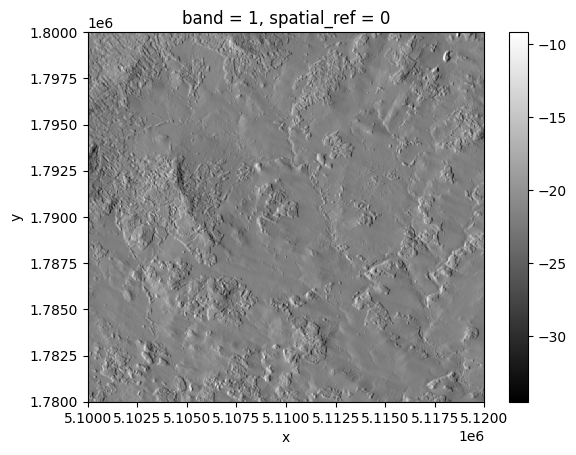

In [16]:
water_bsc_dc.band(0).execute()[:1000, :1000].plot.imshow(cmap='gray')

In [ ]:
flood_mask = bayesian_flood_decision(sig0_dc, expected_bsc_dc, std_dc, water_bsc_dc)

In [17]:
exp_bsc = expected_bsc_dc.execute()[:1000, :1000]

In [18]:
exp_bsc = exp_bsc.load()

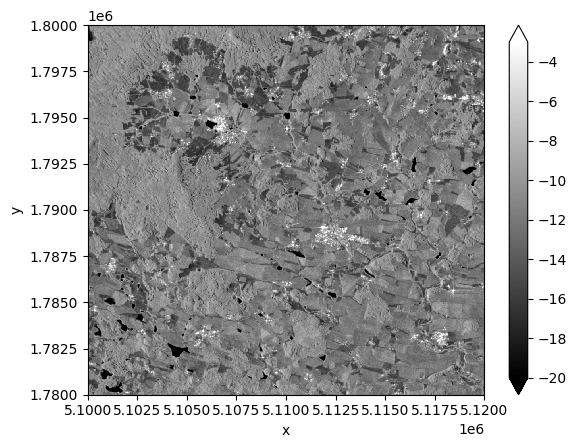

In [19]:
exp_bsc.plot.imshow(vmin=-20, vmax=-3, cmap='gray')

## Data tests

In [4]:
m0 = hparam_dc.band('M0').execute()

In [6]:
m0 = m0.load()

In [6]:
m0.dtype

dtype('float64')

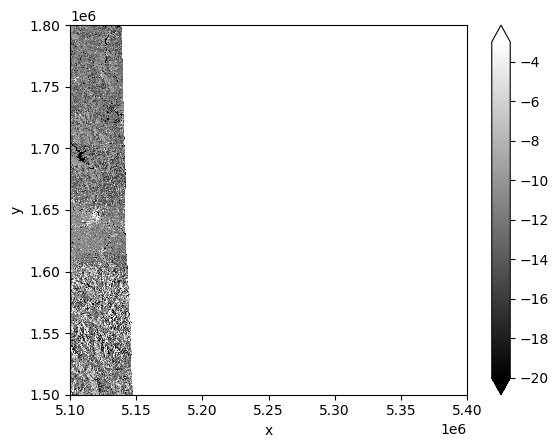

In [7]:
m0.squeeze().plot.imshow(vmin=-20, vmax=-3, cmap='gray')